# Replace LEC and MWTP's CI with Statistical

In [ ]:
%pwd

In [ ]:
%cd ..

## Import Package

In [ ]:
import geopandas as gpd
import matplotlib.colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from shapely.geometry import Point
from shapely.geometry import box
from shapely.ops import unary_union

## load data

In [ ]:
result_df_ndvi = pd.read_excel('13_Results/PdpConnectionCoef/PdpConnection_NDVI_v2.xlsx', index_col = 0)

In [ ]:
result_df_ndvi['significant'] = (result_df_ndvi['coeff'].abs() - result_df_ndvi['SE_coeff'] * 1.96) >= 0

In [ ]:
result_df_ndvi_insignificant = result_df_ndvi[result_df_ndvi['significant'] == False]

In [ ]:
result_df_ndvi.loc[result_df_ndvi['r2'] < 0.5, 'coeff'] = 0

In [ ]:
result_df_ndvi_loc = result_df_ndvi.drop_duplicates()

In [ ]:
result_df_ndvi_loc = result_df_ndvi_loc[['lat', 'lon', 'coeff', 'SE_coeff']]

In [ ]:
result_df_ndvi_loc.columns = ['lat', 'lon', 'coeff_ndvi', 'SE_coeff_ndvi']

In [ ]:
result_df_ntl = pd.read_excel('13_Results/PdpConnectionCoef/PdpConnection_NTL_v2.xlsx', index_col = 0)

In [ ]:
result_df_ntl['significant'] = (result_df_ntl['coeff'].abs() - result_df_ntl['SE_coeff'] * 1.96) >= 0

In [ ]:
result_df_ntl_insignificant = result_df_ntl[result_df_ntl['significant'] == False]

In [ ]:
result_df_ntl.loc[result_df_ntl['r2'] < 0.5, 'coeff'] = 0

In [ ]:
result_df_ntl_loc = result_df_ntl.drop_duplicates()

In [ ]:
result_df_ntl_loc = result_df_ntl_loc[['lat', 'lon', 'coeff', 'SE_coeff']]

In [ ]:
result_df_ntl_loc.columns = ['lat', 'lon', 'coeff_ntl', 'SE_coeff_ntl']

In [ ]:
result_df_income = pd.read_excel('13_Results/PdpConnectionCoef/PdpConnection_income_indiv_v2.xlsx', index_col = 0)

In [ ]:
result_df_income['significant'] = (result_df_income['coeff'].abs() - result_df_income['SE_coeff'] * 1.96) >= 0

In [ ]:
result_df_income_insignificant = result_df_income[result_df_income['significant'] == False]

In [ ]:
result_df_income.loc[result_df_income['r2'] < 0.5, 'coeff'] = 0

In [ ]:
result_df_income_loc = result_df_income.drop_duplicates()

In [ ]:
result_df_income_loc = result_df_income_loc[['lat', 'lon', 'coeff', 'SE_coeff']]

In [ ]:
result_df_income_loc.columns = ['lat', 'lon', 'coeff_income', 'SE_coeff_income']

## Distribution

In [ ]:
merged_df = pd.merge(result_df_ndvi_loc, result_df_ntl_loc, on=['lat', 'lon'], how='left')
result_df_loc_merge = pd.merge(merged_df, result_df_income_loc, on=['lat', 'lon'], how='left')

In [ ]:
result_df_loc_merge['MWPT_NDVI'] = result_df_loc_merge['coeff_ndvi'] / result_df_loc_merge['coeff_income'] / 120.96 * 1_000_000

In [ ]:
result_df_loc_merge['MWPT_NTL'] = result_df_loc_merge['coeff_ntl'] / result_df_loc_merge['coeff_income'] / 120.96 * 1_000_000

In [ ]:
result_df_loc_merge = result_df_loc_merge.groupby(['lat', 'lon']).mean()

In [ ]:
result_df_loc_merge = result_df_loc_merge.reset_index()

In [ ]:
result_df_loc_merge = result_df_loc_merge.replace([np.inf, -np.inf], 0) ### this is from divide 0 error
result_df_loc_merge = result_df_loc_merge.fillna(0)

In [ ]:
lines = []
for name in ['coeff_ndvi', 'coeff_ntl', 'coeff_income', 'MWPT_NDVI', 'MWPT_NTL']:
    
    line = [np.mean(result_df_loc_merge[name]), np.std(result_df_loc_merge[name]), 
            np.quantile(result_df_loc_merge[name], .005),
            np.quantile(result_df_loc_merge[name], .025), np.quantile(result_df_loc_merge[name], .05),
            np.quantile(result_df_loc_merge[name], .25), np.quantile(result_df_loc_merge[name], .50), 
            np.quantile(result_df_loc_merge[name], .75), np.quantile(result_df_loc_merge[name], .95),
            np.quantile(result_df_loc_merge[name], .975), np.quantile(result_df_loc_merge[name], .995)]
    lines.append(line)

In [ ]:
data_summary = pd.DataFrame(lines)

In [ ]:
data_summary.columns = ['Mean', "Std", "0.5% Quantile", "2.5% Quantile", "5% Quantile",
                        "25% Quantile", "50% Quantile",
                        "75% Quantile", "95% Quantile", "97.5% Quantile", "99.5% Quantile"]

In [ ]:
data_summary.index = ['Local Marginal Effect Coefficient of NDVI', 'Local Marginal Effect Coefficient NTL', 'Local Marginal Effect  Coefficient Income', 'MWTP of NDVI', 'MWTP of NTL']

In [ ]:
data_summary.T.to_excel('13_Results/Table02_summaryTable_v2.xlsx')

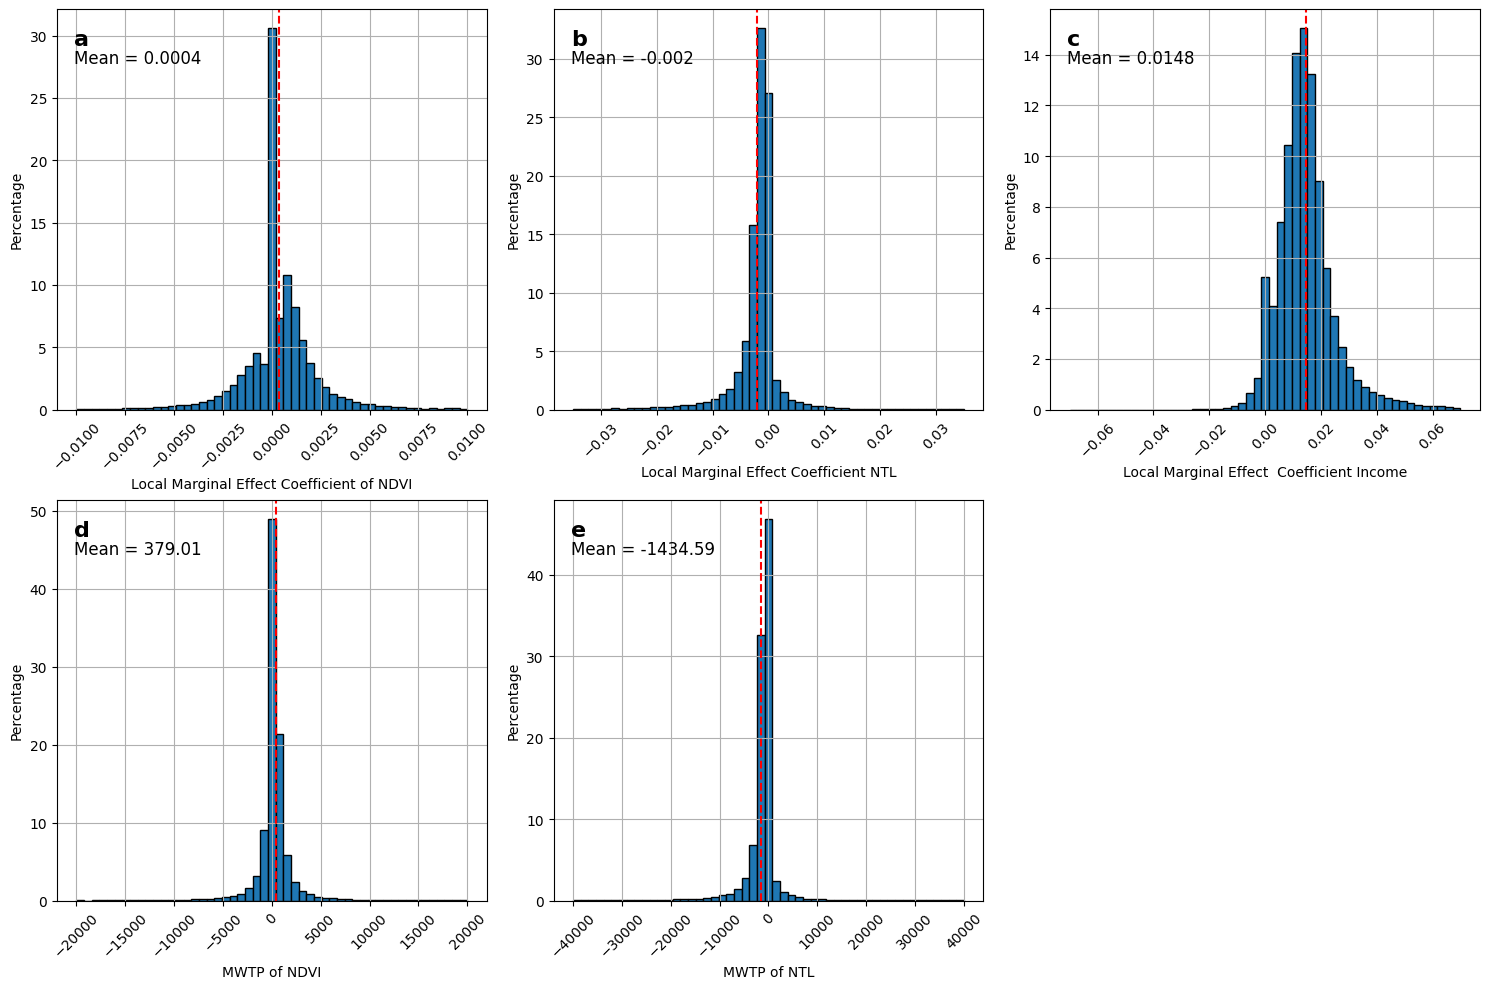

In [166]:
columns_to_plot = ['coeff_ndvi', 'coeff_ntl', 'coeff_income', 'MWPT_NDVI', 'MWPT_NTL']
xnames = ['Local Marginal Effect Coefficient of NDVI', 
          'Local Marginal Effect Coefficient NTL', 
          'Local Marginal Effect  Coefficient Income', 
          'MWTP of NDVI', 
          'MWTP of NTL']
vmaxs = [0.01, 0.035, 0.07, 20_000, 40_000]
labels = ['a', 'b', 'c', 'd', 'e']  # subplot labels
means = [0.000364, -0.002037, 0.014759, 379.011353, -1434.594657]
label_means = [0.0004, -0.0020, 0.0148, 379.01, -1434.59]

# Set up the figure
plt.figure(figsize=(15, 10))

# Loop through each column and plot
for i, col in enumerate(columns_to_plot, 1):
    if i <= 5:
        plt.subplot(2, 3, i)
        data = result_df_loc_merge[col].dropna()
        hist_range = (-vmaxs[i - 1], vmaxs[i - 1])
        counts, bins = np.histogram(data, bins=51, range=hist_range)
        counts_percent = 100 * counts / counts.sum()
        plt.bar(bins[:-1], counts_percent, width=np.diff(bins), edgecolor='black', align='edge')
        plt.xlabel(xnames[i - 1])
        plt.ylabel('Percentage')
        plt.xticks(rotation=45)
        plt.grid(True)

        plt.axvline(x=means[i-1], color='red', linestyle='--', linewidth=1.5)

        # Add annotation in top-left corner of the subplot
        plt.text(0.04, 0.95, f'{labels[i - 1]}', transform=plt.gca().transAxes,
                 fontsize=16, fontweight='bold', va='top', ha='left')
                # Add annotation in top-left corner of the subplot
        plt.text(0.04, 0.90, f'Mean = {label_means[i - 1]}', transform=plt.gca().transAxes,
                 fontsize=12, va='top', ha='left')
    else:
        plt.axis("off")

plt.tight_layout()
plt.savefig("11_Figure/histograms_with_means.jpg", dpi=300, bbox_inches='tight')
plt.show()